## 1. Import Libraries

In [23]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, HTML

## 2. Parameter

In [24]:
# declare path
train_dir = '../archive/train'
test_dir = '../archive/test'

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

## 3. Prepare data

In [25]:
# Data augmentation

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [56]:
# Load datasat

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  shuffle =False,
                                                  batch_size = 64)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## 4. Explore data

../archive/train/angry/Training_10120469.jpg
../archive/train/disgust/Training_10598340.jpg
../archive/train/fear/Training_10031494.jpg
../archive/train/happy/Training_10046809.jpg
../archive/train/neutral/Training_10031781.jpg
../archive/train/sad/Training_10031481.jpg
../archive/train/surprise/Training_1002457.jpg


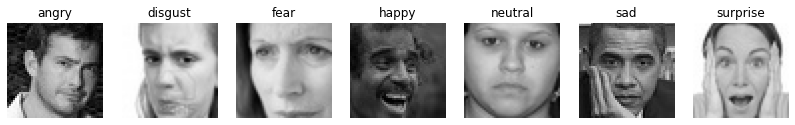

In [7]:
# Plot image of each class

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    print(train_dir + "/" + expression + '/' + os.listdir(train_dir +"/"+ expression)[1])
    img = tf.keras.preprocessing.image.load_img((train_dir + "/" + expression + '/' + os.listdir(train_dir +"/"+ expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# 5. Model

In [58]:
# VGG16
base_model = tf.keras.applications.VGG16(input_shape= (48, 48, 3),include_top=False,weights="imagenet")
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [59]:
# Here to build Improved VGG-16 model

model=tf.keras.models.Sequential()
model.add(base_model)

# ,bias_regularizer=tf.keras.regularizers.l2()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(),))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(),))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(7, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 7)                

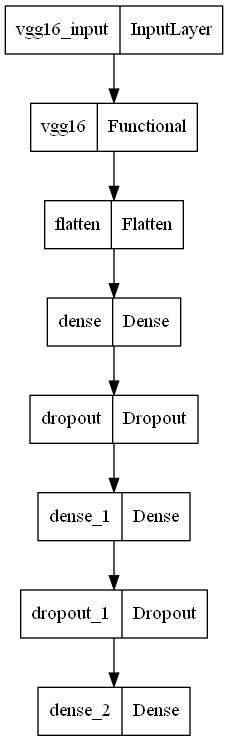

In [7]:
# plot the model
tf.keras.utils.plot_model(model, to_file='model.jpg')

In [62]:
# Compile model

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      'accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [10]:
# run the model
es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=70)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = 100,
                  verbose =1,
                  callbacks=[es])


Epoch 1/100
449/449 [==============================] - 31s 59ms/step - loss: 4.7907 - accuracy: 0.3900 - precision: 0.7333 - recall: 0.1560 - auc: 0.7724 - f1_score: 0.2439 - val_loss: 3.1559 - val_accuracy: 0.5318 - val_precision: 0.7715 - val_recall: 0.2997 - val_auc: 0.8707 - val_f1_score: 0.4294
Epoch 2/100
449/449 [==============================] - 25s 56ms/step - loss: 2.6108 - accuracy: 0.5268 - precision: 0.7391 - recall: 0.3146 - auc: 0.8617 - f1_score: 0.4374 - val_loss: 2.0534 - val_accuracy: 0.5756 - val_precision: 0.7709 - val_recall: 0.3915 - val_auc: 0.8957 - val_f1_score: 0.5164
Epoch 3/100
449/449 [==============================] - 25s 56ms/step - loss: 1.8947 - accuracy: 0.5726 - precision: 0.7405 - recall: 0.3871 - auc: 0.8870 - f1_score: 0.5061 - val_loss: 1.6599 - val_accuracy: 0.5960 - val_precision: 0.7462 - val_recall: 0.4465 - val_auc: 0.9035 - val_f1_score: 0.5569
Epoch 4/100
449/449 [==============================] - 25s 57ms/step - loss: 1.5839 - accuracy: 0

In [17]:
# save model weights
model.save_weights('../Project/weights/weight3')

In [63]:
# load model weights
model.load_weights('../Project/weights/weight3')

## 6. Evaluate Model

### 6.1 Check some Score 

In [64]:
# evaluation of train & test set

train_evaluation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

113/113 [==============================] - 9s 75ms/step - loss: 1.7619 - accuracy: 0.6803 - precision: 0.6887 - recall: 0.6714 - auc: 0.8895 - f1_score: 0.6809


In [12]:
metric_list = ["Loss","accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evaluation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))




Model Scores



,Metric Name,Train,Validate
0,Loss,0.098,1.762
1,accuracy,0.968,0.680
2,Precision,0.972,0.689
3,Recall,0.964,0.671
4,Auc,0.999,0.890
5,F1_Score,0.968,0.682


### 6.2 Visualize results

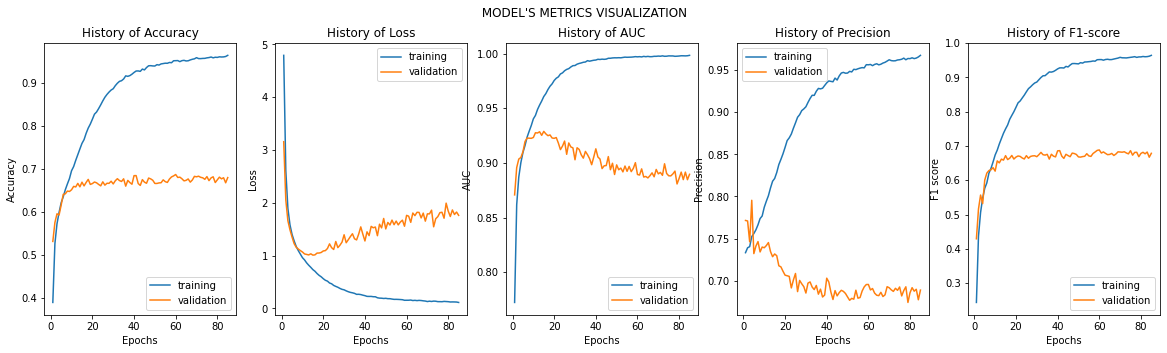

In [13]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']              

# plt.style.use('Solarize_Light2')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

### 6.3 Confusion Matrix

In [69]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

113/113 [==============================] - 9s 76ms/step


Confusion matrix, without normalization

[[ 582    8   96   34  101  128    9]
 [  14   72    7    2    6    8    2]
 [ 111    3  527   27  120  158   78]
 [  34    0   27 1477  149   45   42]
 [  63    1   72   60  873  142   22]
 [ 124    7  137   38  255  667   19]
 [  20    0   50   23   29   24  685]]





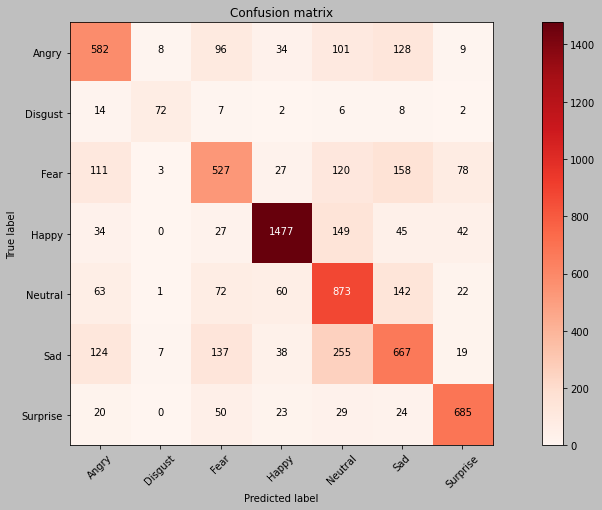

In [74]:
plt.rcParams['figure.figsize'] = (14,7)

# plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

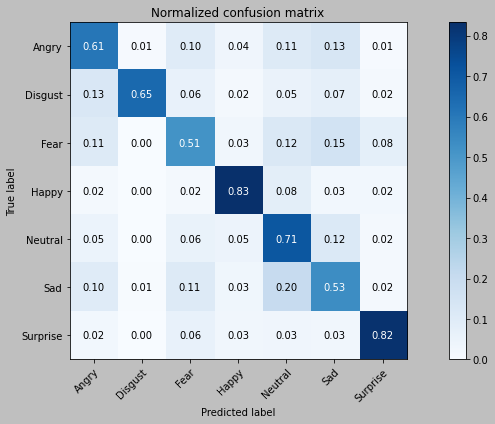

In [68]:
# plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,6))

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title = 'Normalized confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()


## 7. Test example

(48, 48, 1)


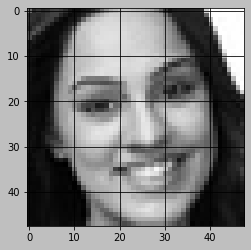

In [20]:
plt.style.use('grayscale')
plt.grid(visible=None)
img_path='../archive/test/happy/PrivateTest_10613684.jpg'
test_image=tf.keras.preprocessing.image.load_img(img_path,target_size= (48, 48),color_mode='grayscale')
test_image=tf.keras.preprocessing.image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(test_image)
plt.show()

In [21]:
img=tf.keras.preprocessing.image.load_img(img_path,target_size=(48, 48))
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 48, 48, 3)


In [22]:
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',classes[y_pred])

1/1 [==============================] - 0s 24ms/step
[0. 0. 0. 1. 0. 0. 0.]
The person facial emotion is: Happy
